In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from scipy.signal import find_peaks
import scipy.signal.windows as win
import scipy as sp
import warnings
import re
from ipywidgets import interact,widgets
from scipy.optimize import curve_fit
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.misc import derivative
from matplotlib.colors import hsv_to_rgb
import warnings
from functions_master import *
from glob import glob
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

# Reference.

9e-10 

In [2]:

# Suprimir FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


c = 0.299792458 # speed of light mm/ps

def FourierT2(f,N):
    return np.conj(sp.fft.fft(f.values,n=N))

def calcular_n(omega, phi_exp, c, d):

    return 1 + (c / (omega * d)) * phi_exp

def calcular_kappa(omega, T_exp, n, c, d):

    term = ((n + 1)**2 / (4 * n)) * T_exp
    return -(c / (omega * d)) * np.log(term)


def extraer_angulos(nombres_archivos):
    """
    Extrae el patrón que está después del último '__' y antes de '.dat'
    Ejemplo: '...__hori-80deg.dat' → 'hori-80deg'
    """
    patrones = []
    patron_regex = re.compile(r'__([^__]+)\.dat$')  # Captura lo entre último __ y .dat
    
    for nombre in nombres_archivos:
        coincidencia = patron_regex.search(nombre)
        if coincidencia:
            patrones.append(coincidencia.group(1))
    
    return patrones


In [3]:
# Configuración desde el archivo txt (simulada aquí como un diccionario)
config = {
    'figure.constrained_layout.use': True,
    'figure.figsize': (5.4, 3.2),
    'figure.titlesize': 'small',
    'figure.labelsize': 'small',
    'font.size': 10,
    'font.family': 'serif',
    'text.usetex': False,
    'pgf.texsystem': 'lualatex',
    'pgf.rcfonts': False,
    'pgf.preamble': r'\usepackage{siunitx,fontspec}\setmainfont{Times New Roman}',
    'lines.linewidth': 1,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 4,
    'legend.frameon': False,
    'legend.markerscale': 0.8,
    'legend.fontsize': 'small',
    'legend.title_fontsize': 'small',
    'legend.handlelength': 1.5,
    'legend.handletextpad': 0.2,
    'xtick.top': True,
    'xtick.major.size': 5,
    'xtick.major.width': 0.8,
    'xtick.minor.width': 0.8,
    'xtick.minor.size': 3,
    'xtick.labelsize': 'small',
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.major.size': 5,
    'ytick.major.width': 0.8,
    'ytick.minor.width': 0.8,
    'ytick.minor.size': 3,
    'ytick.labelsize': 'small',
    'ytick.direction': 'in',
    'axes.linewidth': 0.8,
    'axes.axisbelow': False,
    'axes.labelsize': 'medium',
    'axes.labelpad': 2,
    'figure.constrained_layout.h_pad': 0.02,
    'figure.constrained_layout.w_pad': 0.01,
    'figure.constrained_layout.hspace': 0.02,
    'figure.constrained_layout.wspace': 0.02,
    'svg.fonttype': 'none'
}

# Aplicar la configuración
#plt.rcParams.update(config)#

In [4]:
ruta_actual = os.getcwd()  # Muestra la ruta actual

In [5]:
ruta_actual

'c:\\Users\\esteb\\Escritorio\\physics\\mestrado_thz_physics\\Materials\\analisis_datos_rapido (1)\\analisis_datos_rapido'

In [6]:
ruta_actual = os.getcwd()

sample1_ang_csv = os.path.join(ruta_actual,"sample1_ang.csv")
sample2_ang_csv= os.path.join(ruta_actual,"sample2_ang.csv")

carpeta_sample1 = os.path.join(ruta_actual,"src\\sample1_ang")
carpeta_ref_sample1 = os.path.join(ruta_actual,"src\\reference1")

sample1_med = glob(os.path.join(carpeta_sample1, "*"))
rutas_ref_sample1 = glob(os.path.join(carpeta_ref_sample1, "*"))

archivos_dat_ref = glob(os.path.join(os.path.join(carpeta_ref_sample1,'carpeta1'), '*.dat'))
archivos_dat_samp = glob(os.path.join(os.path.join(carpeta_sample1,'carpeta1'), '*.dat'))


# Elimina cada archivo
for archivo in archivos_dat_samp:
    os.remove(archivo)
    #print(f'Archivo {archivo} eliminado.')

for archivo in archivos_dat_ref:
    os.remove(archivo)
    #print(f'Archivo {archivo} eliminado.')

In [7]:
convert_dats(carpeta_ref_sample1,3)
convert_dats(carpeta_sample1,3)

Archivo c:\Users\esteb\Escritorio\physics\mestrado_thz_physics\Materials\analisis_datos_rapido (1)\analisis_datos_rapido\src\reference1\carpeta1\Average_294.4K.dat generado en c:\Users\esteb\Escritorio\physics\mestrado_thz_physics\Materials\analisis_datos_rapido (1)\analisis_datos_rapido\src\reference1\carpeta1.
Archivo c:\Users\esteb\Escritorio\physics\mestrado_thz_physics\Materials\analisis_datos_rapido (1)\analisis_datos_rapido\src\sample1_ang\carpeta1\Average_16.4K.dat generado en c:\Users\esteb\Escritorio\physics\mestrado_thz_physics\Materials\analisis_datos_rapido (1)\analisis_datos_rapido\src\sample1_ang\carpeta1.
Archivo c:\Users\esteb\Escritorio\physics\mestrado_thz_physics\Materials\analisis_datos_rapido (1)\analisis_datos_rapido\src\sample1_ang\carpeta1\Average_40.6K.dat generado en c:\Users\esteb\Escritorio\physics\mestrado_thz_physics\Materials\analisis_datos_rapido (1)\analisis_datos_rapido\src\sample1_ang\carpeta1.
Archivo c:\Users\esteb\Escritorio\physics\mestrado_thz_p

In [8]:
# Filtrar y ordenar los archivos por la temperatura
archivos_dat_ref = sorted(
    archivos_dat_ref,
    key=lambda x: extraer_temperatura(x)
)

archivos_dat_samp = sorted(
    archivos_dat_samp,
    key=lambda x: extraer_temperatura(x)
)

# FULL DATA

In [9]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [10]:
def anim2(left,right_sample,right_subs,index,desv,d):
    
    right_ref= right_subs
    left = left
    N = 2**15

    f = plt.figure(figsize=(7, 7), dpi=200)

# Configuración de gridspec: 2 filas, 2 columnas, con alturas relativas 3:1
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1], width_ratios=[1, 1])

    # --- Primera fila (más grande) ---
    ax1 = plt.subplot(gs[0, 0])  # Subplot 221
    ax2 = plt.subplot(gs[0, 1])  # Subplot 222

    # --- Segunda fila (más pequeña) ---
    ax3 = plt.subplot(gs[1, 0])  # Subplot 223
    ax4 = plt.subplot(gs[1, 1])  # Subplot 224

    print(index)
    path_signal = archivos_dat_samp[int(index)]
    path_ref = archivos_dat_ref[0]
    
    j = round(index)
    print(j)

    num_files = len(sample1_med)
    angles = np.linspace(0, 360, num_files, endpoint=False)  # ángulos de 0 a 350

    # Usar un mapa de colores cíclico
    # colors = [hsv_to_rgb([angle / 360.0, 0.6, 0.85]) for angle in angles]

    params_window1 =  ['nuttall']# ['gaussian', desv] #['nuttall']#['flattop'] #['gaussian', desv]#['nuttall'] #['kaiser',desv] #['flattop']# ['gaussian', desv]


    phase, y_signal_ventaneada, y_substrate_padding, ventana = getSignalWindowed(path_signal,
                                                                                 path_ref,
                                                                                 left,
                                                                                 right_sample,
                                                                                 right_subs,
                                                                                 params_window1)

    y_subs_ventana = pd.Series(y_substrate_padding*ventana)

    y_signal_ventaneada = pd.Series(y_signal_ventaneada*ventana)


    val = 2
    
    ax1.plot(y_subs_ventana/max(y_subs_ventana), 'k',label='Ref')
    ax1.plot(ventana/max(ventana), 'k--',label='Window')
    ax1.set_title("Signals")

    ax1.plot(y_signal_ventaneada/max(y_signal_ventaneada) + val,label='Sam')
    ax1.plot(ventana/max(ventana) + val, 'k--')
    ax1.legend(loc='lower right')
        

    right_sample = right_sample


    # params_window1 = ['flattop'] #['gaussian', desv]
    k = 15
    nu = sp.fft.fftfreq(N, 1/30)
        # Aplicar ventana de Hamming a la señal
    
    fft_y_signal_ventaneada = FourierT2(y_signal_ventaneada,N)[1:len(nu)//k]
    fft_y_subs_ventaneada = FourierT2(y_subs_ventana,N)[1:len(nu)//k]

    # fft_window = FourierT2(pd.Series(ventana),N)[1:len(nu)//k]

    # Filtrar las frecuencias
    nu = nu[1:len(nu)//k]
    xmin, xmax = 0.15, 1.0
    mask = (nu >= xmin) & (nu <= xmax)

    fft_y_signal_ventaneada = fft_y_signal_ventaneada[mask]
    fft_y_subs_ventaneada = fft_y_subs_ventaneada[mask]
    nu_filtradas = nu[mask]

    T = fft_y_signal_ventaneada/fft_y_subs_ventaneada*np.exp(-1j*2*np.pi*nu_filtradas*phase*1/30)
    d = d
    
    T_exp = abs(T)

    phi_exp = np.angle(T)

    phi_exp = np.unwrap(phi_exp)

    # plt.plot(nu_filtradas,abs(T)/max(abs(T)))
    # plt.yscale('log')


    ax2.plot(nu_filtradas, abs(T)**2/max(abs(T)**2))
    ax2.set_ylabel(r"$|T|^2$")
    ax2.set_yscale('log')

  

    # =============================================
    # Gráficos 223 y 224 (segunda fila)
    # =============================================
    # Gráfico 223 (ax3)
    n = calcular_n(nu_filtradas*2*np.pi, phi_exp, c, d)
    ax3.plot(nu_filtradas, n,'k')
    ax3.set_xlabel(r"$\nu$ (THz)")
    ax3.set_ylabel(r"$n$")

    # Gráfico 224 (ax4)
    ax4.set_ylabel(r"$\kappa$")
    # ax4.set_title(angulos_sample1[j])
    temp = extraer_temperatura(path_signal)
    ax4.plot(nu_filtradas, calcular_kappa(nu_filtradas*2*np.pi, T_exp, n, c, d),'k',label=f'{temp} K')
    ax4.set_xlabel(r"$\nu$ (THz)")
    ax4.legend()

# Ajuste final
# plt.tight_layout()



    # plt.legend(bbox_to_anchor=(1.05, 3.0), loc='upper left', title="Ángulo de polarización")
    plt.tight_layout()

opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        left= widgets.FloatSlider(min=40,max=70,value=53,step=0.1,**opc),
        right_sample= widgets.FloatSlider(min=50,max=70,value=63.5,step=0.1,**opc),
        right_subs= widgets.FloatSlider(min=50,max=70,value=63.5,step=0.1,**opc),
        index= widgets.FloatSlider(min=0,max=len(sample1_med)-1,value=0,step=1,**opc),
        desv = widgets.FloatSlider(min=0,max=1000,value=150,step=0.001,**opc),
        d = widgets.FloatSlider(min=0,max=1,value=0.627,step=0.01,**opc)

        )

interactive(children=(FloatSlider(value=53.0, continuous_update=False, description='left', max=70.0, min=40.0,…

<function __main__.anim2(left, right_sample, right_subs, index, desv, d)>

In [29]:
import matplotlib.animation as animation
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from colorsys import hsv_to_rgb
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# Asegúrate de tener estas funciones y variables definidas fuera (aquí solo están referenciadas)
# - extraer_temperatura
# - getSignalWindowed
# - FourierT2
# - calcular_n
# - calcular_kappa
# - sample1_med
# - archivos_dat_ref
# - c

def create_frame(index, left, right_sample, right_subs, desv, d, axes, norm, cmap):
    ax1, ax2, ax3, ax4 = axes

    # Limpiar los ejes en lugar de fig.clear()
    for ax in axes:
        ax.clear()

    path_signal = archivos_dat_samp[int(index)]
    temp = extraer_temperatura(path_signal)
    color = cmap(norm(temp)) if temp is not None else 'blue'
    path_ref = archivos_dat_ref[0]

    N = 2**15
    params_window1 = ['nuttall']

    phase, y_signal_ventaneada, y_substrate_padding, ventana = getSignalWindowed(
        path_signal, path_ref, left, right_sample, right_subs, params_window1)

    y_subs_ventana = pd.Series(y_substrate_padding * ventana)
    y_signal_ventaneada = pd.Series(y_signal_ventaneada * ventana)

    val = 2

    ax1.plot(y_subs_ventana / max(y_subs_ventana), 'k', label='Ref')
    ax1.plot(ventana / max(ventana), 'k--', label='Window')
    ax1.plot(y_signal_ventaneada / max(y_signal_ventaneada) + val, color=color, label='Sam')
    ax1.plot(ventana / max(ventana) + val, 'k--')
    # ax1.set_title(f"T = {temp} K" if temp is not None else "Temperatura no disponible")
    ax1.legend(loc='lower right')

    k = 15
    nu = sp.fft.fftfreq(N, 1 / 30)
    fft_y_signal_ventaneada = FourierT2(y_signal_ventaneada, N)[1:len(nu)//k]
    fft_y_subs_ventaneada = FourierT2(y_subs_ventana, N)[1:len(nu)//k]

    nu = nu[1:len(nu)//k]
    xmin, xmax = 0.15, 1.2
    mask = (nu >= xmin) & (nu <= xmax)

    fft_y_signal_ventaneada = fft_y_signal_ventaneada[mask]
    fft_y_subs_ventaneada = fft_y_subs_ventaneada[mask]
    nu_filtradas = nu[mask]

    T = fft_y_signal_ventaneada / fft_y_subs_ventaneada * np.exp(-1j * 2 * np.pi * nu_filtradas * phase * 1 / 30)

    T_exp = abs(T)
    phi_exp = np.unwrap(np.angle(T))

    ax2.plot(nu_filtradas, abs(T)**2 / max(abs(T)**2), color=color)
    ax2.set_ylabel(r"$|T|^2$")
    ax2.set_yscale('log')

    n = calcular_n(nu_filtradas * 2 * np.pi, phi_exp, c, d)
    ax3.plot(nu_filtradas, n, color=color)
    ax3.set_xlabel(r"$\nu$ (THz)")
    ax3.set_ylabel(r"$n$")

    kappa = calcular_kappa(nu_filtradas * 2 * np.pi, T_exp, n, c, d)
    ax4.plot(nu_filtradas, kappa, color=color, label=f'{temp:.1f} K')
    ax4.set_xlabel(r"$\nu$ (THz)")
    ax4.set_ylabel(r"$\kappa$")
    ax4.legend()

def generate_gif():
    temps = []
    for path in archivos_dat_samp:
        temp = extraer_temperatura(path)
        if temp is not None:
            temps.append(temp)

    if not temps:
        raise ValueError("No se encontraron temperaturas válidas en los archivos")

    min_temp, max_temp = min(temps), max(temps)
    norm = Normalize(vmin=min_temp, vmax=max_temp)
    cmap = cm.coolwarm

    left = 53.0
    right_sample = 63.5
    right_subs = 63.5
    desv = 150.0
    d = 0.627

    fig = plt.figure(figsize=(7, 7), dpi=200)
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1], width_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    axes = [ax1, ax2, ax3, ax4]

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    fig.colorbar(sm, cax=cbar_ax, label='Temperature (K)')

    def animate(i):
        create_frame(i, left, right_sample, right_subs, desv, d, axes, norm, cmap)
        return axes
    carpeta = os.getcwd()
    ruta_guardado = os.path.join(carpeta, 'animacion_temperatura3.gif')
    ani = animation.FuncAnimation(fig, animate, frames=len(archivos_dat_samp), interval=400, blit=False)
    ani.save(ruta_guardado, writer=animation.PillowWriter(fps=2), dpi=200)
    plt.close()

# Ejecutar
generate_gif()


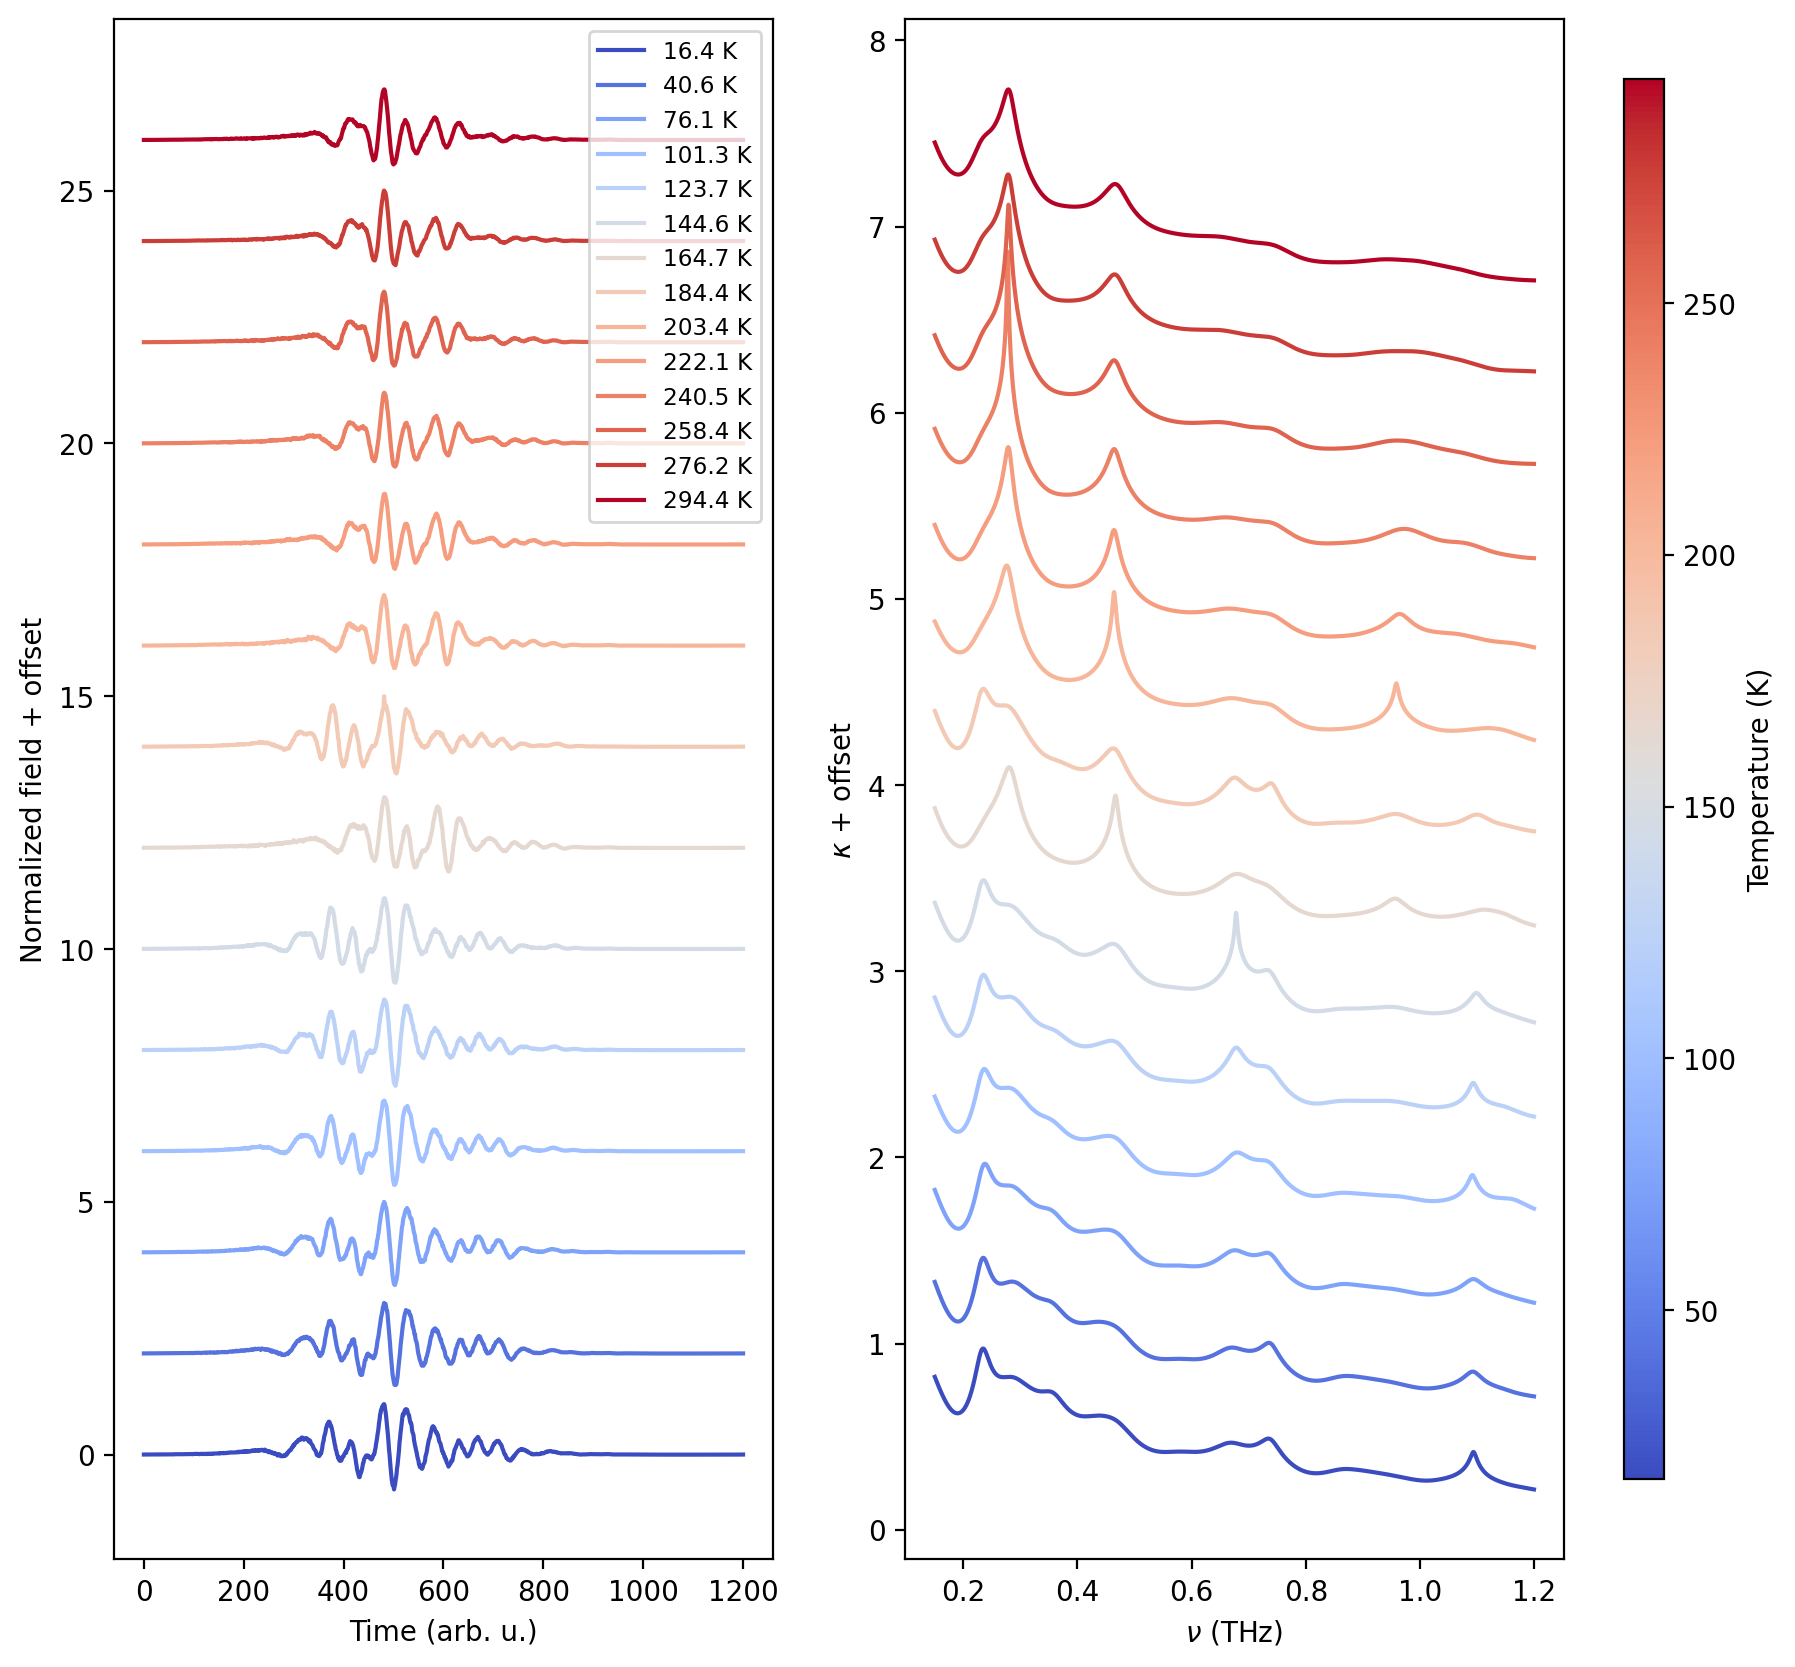

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import cm
from matplotlib.colors import Normalize
import os

def plot_all_samples(left, right_sample, right_subs, desv, d, val_offset_signal=2, val_offset_kappa=0.03):
    temps = [extraer_temperatura(p) for p in sample1_med if extraer_temperatura(p) is not None][::-1]

    if not temps:
        raise ValueError("No se encontraron temperaturas válidas en los archivos")

    min_temp, max_temp = min(temps), max(temps)
    norm = Normalize(vmin=min_temp, vmax=max_temp)
    cmap = cm.coolwarm

    N = 2**15
    params_window1 = ['nuttall']
    fig, (ax1, ax4) = plt.subplots(1, 2, figsize=(10, 10), dpi=200)

    # ax1.set_title("Señal ventaneada + ventana (todas las muestras)")
    ax1.set_ylabel("Normalized field + offset")
    ax1.set_xlabel("Time (arb. u.)")

    # ax4.set_title(r"Coeficiente de extinción $\kappa$ (todas las muestras)")
    ax4.set_xlabel(r"$\nu$ (THz)")
    ax4.set_ylabel(r"$\kappa$ + offset")

    for index, path_signal in enumerate(archivos_dat_samp):
        temp = temps[index]
        color = cmap(norm(temp)) if temp is not None else 'blue'
        path_ref = archivos_dat_ref[0]

        phase, y_signal_ventaneada, y_substrate_padding, ventana = getSignalWindowed(
            path_signal, path_ref, left, right_sample, right_subs, params_window1)

        y_subs_ventana = pd.Series(y_substrate_padding * ventana)
        y_signal_ventaneada = pd.Series(y_signal_ventaneada * ventana)

        offset_signal = val_offset_signal * index

        # if index == 0:
        #     ax1.plot(y_subs_ventana / max(y_subs_ventana), 'k', label='Ref')
        #     ax1.plot(ventana / max(ventana), 'k--', label='Window')

        ax1.plot(y_signal_ventaneada / max(y_signal_ventaneada) + offset_signal, color=color, label=f'{temp:.1f} K')

        # FFT y kappa
        k = 15
        nu = sp.fft.fftfreq(N, 1 / 30)
        fft_y_signal_ventaneada = FourierT2(y_signal_ventaneada, N)[1:len(nu)//k]
        fft_y_subs_ventaneada = FourierT2(y_subs_ventana, N)[1:len(nu)//k]

        nu = nu[1:len(nu)//k]
        xmin, xmax = 0.15, 1.2
        mask = (nu >= xmin) & (nu <= xmax)

        fft_y_signal_ventaneada = fft_y_signal_ventaneada[mask]
        fft_y_subs_ventaneada = fft_y_subs_ventaneada[mask]
        nu_filtradas = nu[mask]

        T = fft_y_signal_ventaneada / fft_y_subs_ventaneada * np.exp(-1j * 2 * np.pi * nu_filtradas * phase * 1 / 30)
        T_exp = abs(T)
        phi_exp = np.unwrap(np.angle(T))

        n = calcular_n(nu_filtradas * 2 * np.pi, phi_exp, c, d)
        kappa = calcular_kappa(nu_filtradas * 2 * np.pi, T_exp, n, c, d)
        val_offset_kappa = 0.5
        offset_kappa = val_offset_kappa * index

        ax4.plot(nu_filtradas, kappa + offset_kappa, color=color, label=f'{temp:.1f} K')

    ax1.legend(loc='upper right', fontsize='small')
    # ax4.legend(loc='upper left', fontsize='small')

    # Barra de temperatura al costado
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    fig.colorbar(sm, cax=cbar_ax, label='Temperature (K)')

    plt.show()

# Ejecutar la función
plot_all_samples(left=53.0, right_sample=63.5, right_subs=63.5, desv=150.0, d=0.627)
